In [1]:
%matplotlib inline

import sys
import os
sys.path.append('/Users/selimamrari/Documents/PDM/NCP')

import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
from my_packages.My_Geoprocess import*
import pandas as pd


# Declare model class

In [2]:
class LyzengaMod:
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    from sklearn.metrics import r2_score

    
    def get_X(DeepSample, FootPrint, SoilIndex, bands_data):
        assert str(bands_data.dtype) == 'float32'
        X = np.zeros(bands_data.shape, dtype= np.float32)
        SoilIndex5D = np.tile(SoilIndex[:,:,np.newaxis], (1,1,bands_data.shape[2]))

        for i in range(len(FootPrint)):
            Idx = np.logical_and( np.logical_and(FootPrint[i], ~SoilIndex), np.sum(X == 0, axis=2)>0)

            if np.sum(Idx) > 0:
                IdxDeep = np.logical_and(FootPrint[i], DeepSample)
                if np.sum(IdxDeep) == 0:
                    IdxDeep = np.logical_and(FootPrint[i-1], DeepSample)

                for c in range(bands_data.shape[2]):
                    X[:,:,c][Idx] = bands_data[:,:,c][Idx] - np.min(bands_data[:,:,c][IdxDeep])
                    print('FootPrint: {0:d}, Bande: {1:d}, minimum :{2:0.2f}, average :{3:0.2f}'.format(i,c,np.min(bands_data[:,:,c][IdxDeep]), np.mean(bands_data[:,:,c][IdxDeep])))

        ErrorMap = np.logical_and(X<=0, ~SoilIndex5D)
        X[ErrorMap] = np.nan
        X[~SoilIndex5D] = np.log(X[~SoilIndex5D])
        return X, ErrorMap
        
    def fit(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        try:
            self.Parameters = np.linalg.solve(lnX.T.dot(lnX), lnX.T.dot(Y))
        except np.linalg.LinAlgError as e:
            print(str(e))
            self.Parameters = np.linalg.lstsq(lnX.T.dot(lnX), lnX.T.dot(Y))
            
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.score = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sqrt(np.sum(np.square(ecart))/N), 'Error%':100*np.mean(np.divide(np.abs(ecart),Y)), 'Error':np.sum(np.abs(ecart))/N, 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
    def fit2(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        print('ok')
        
    def predict(self, lnX):
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        assert lnX.shape[1] == self.Parameters.shape[0]
        
        return lnX.dot(self.Parameters)
    
    def predictEval(self, lnX, Y):
        
        assert lnX.shape[0] == Y.shape[0]
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.Testscore = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sqrt(np.sum(np.square(ecart))/N), 'Error%':100*np.mean(np.divide(np.abs(ecart),Y)),'Error':np.sum(np.abs(ecart))/N, 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
         
        return lnX.dot(self.Parameters)
    
    def __init__(self):
        """Constructeur de notre personne."""
        self.Parameters = np.array
        self.score = {}
        self.Testscore = {}
        
def my_RMS (TrueV, PredV):
    ecart = PredV - TrueV
    N = len(ecart)
    return np.sqrt(np.sum(np.square(ecart))/N)

def my_Error100 (TrueV, PredV):
    ecart = PredV - TrueV
    N = len(ecart)
    return 100*(np.sum(np.divide(np.abs(ecart),TrueV)))/N

def my_Error (TrueV, PredV):
    ecart = PredV - TrueV
    N = len(ecart)
    return (np.sum(np.abs(ecart)))/N

In [3]:
from sklearn.linear_model import LinearRegression

In [4]:
class StumpfMod:
    
    from sklearn.linear_model import LinearRegression
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    from sklearn.metrics import r2_score

        
    def fit(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        
        self.model.fit(lnX, Y)
        ecart = self.model.predict(lnX) - Y
        N = len(ecart)
        self.score = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sqrt(np.sum(np.square(ecart))/N), 'Error%':100*np.mean(np.divide(np.abs(ecart),Y)), 'Error':np.sum(np.abs(ecart))/N, 'R2': r2_score(Y, self.model.predict(lnX))}
        
        
    def predict(self, lnX):
        
        
        return self.model.predict(lnX)
    
    def predictEval(self, lnX, Y):
        
        ecart = self.model.predict(lnX) - Y
        N = len(ecart)
        self.Testscore = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sqrt(np.sum(np.square(ecart))/N), 'Error%':100*np.mean(np.divide(np.abs(ecart),Y)),'Error':np.sum(np.abs(ecart))/N, 'R2': r2_score(Y, self.model.predict(lnX))}
        
         
        return self.model.predict(lnX)
    
    def __init__(self):
        """Constructeur de notre personne."""
        self.model = LinearRegression()
        self.score = {}
        self.Testscore = {}
        

# Open Satellite file and deglingt image

In [5]:
xml_filePath = "/Users/selimamrari/Documents/PDM/NCP/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/"
xml_fileName = "MTD_MSIL1C.xml"
gdal.ErrorReset()
ds = gdal.Open( xml_filePath + xml_fileName )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
SubDataSet_md = ds.GetMetadata('SUBDATASETS')
ds = []
DataSet_md


{'CLOUD_COVERAGE_ASSESSMENT': '0.7371',
 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((166.35532632901763 -21.6970894719947, 166.46954229960608 -21.722967647825207, 166.46958826624325 -21.7227815159352, 166.47163316358743 -21.7232445791535, 166.4716453848504 -21.723194893765147, 166.47183341263485 -21.72323722848605, 166.4718497080836 -21.72317095690131, 166.71071733633568 -21.7773031127493, 166.71050830013448 -21.778173871448455, 166.9264041597562 -21.83047594674156, 166.92645036494807 -21.830281694363315, 166.92658079158798 -21.830313185021467, 166.9266070084699 -21.830202736161407, 166.92874668649648 -21.830719126399448, 166.928830

In [6]:
# Try opening the 4 subdatasets
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
src_ds = ds[0]
ds[0].RasterCount


4

# Define image extent

In [7]:
# Define Raster Footprint

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
GT_ds = src_ds.GetGeoTransform()
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, max_N), '\nLower right corner : ', (max_E, min_N))


Upper left corner :  (165.9735606070099, -21.691015824552036) 
Lower right corner :  (167.02786117314153, -22.692427357900442)


# Select xml datafiles following common extent

In [8]:
RePath_xmlDirectory = '/Users/selimamrari/Documents/PDM/NCP/Data_SHOM/Global'
TimeThres = 1965
#%timeit GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)

# Select xml datafiles following maximum depth

In [9]:
Upto = 30
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]


# Define pixel location of measured data

In [10]:
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

px, py = GetPixel(ctInv, inv_geometrix, Set[1])


with int


# filter measured data projected outside image extent

In [11]:
index = np.logical_or(np.logical_or(py>10979,py<0), np.logical_or(px>10979,px<0))
px, py = px[~index], py[~index]
depth=Set[2][~index]

# Import image data index as compressed

In [12]:
npzfile = np.load('TrainMatrix_all.npz')
ClassifIndex =  npzfile['arr_1']

shapefile_path = ["/Users/selimamrari/Documents/PDM/NCP/Scripts/test/error.shp"]

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
geo_transform = src_ds.GetGeoTransform()
proj = src_ds.GetProjectionRef()

errors = vectors_to_raster(shapefile_path, RasterWidth, RasterHeight, geo_transform, proj)
errors = errors==True
ClassifIndex[errors] = False
del errors,

# Create sub (2d) index for measured pixel

In [13]:
'''SurveyIndex = np.full(ClassifIndex.shape, False, dtype=np.bool_)
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i in range(len(px)):
    try:
        SurveyIndex[py[i],px[i]] = True
        SurveyValues[py[i],px[i]] = depth[i]
    except:
        print(i)'''
depth[:] = depth[:]+0.41

In [14]:
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)


In [15]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.var(Dicto[(i, j)])
    

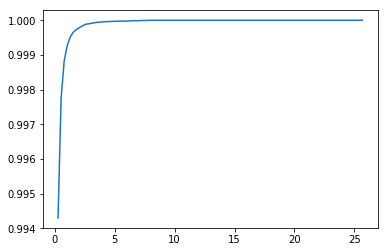

0.0

In [16]:
values, base = np.histogram(SurveyVariance[~np.isnan(SurveyVariance)], bins=100, normed='True')
dx = base[1] - base[0]
plt.plot(base[1:], np.cumsum(values)*dx)
plt.show()
np.median(SurveyVariance[~np.isnan(SurveyVariance)])

In [17]:
index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],50)

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


B02_09.shp


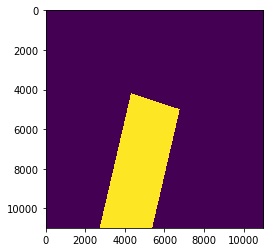

In [455]:
FootprintFilePath = '/Users/selimamrari/Documents/PDM/NCP/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/Mask/FootPrint//'

for File in GetSimpleFiles("B02_09.shp", directory=FootprintFilePath):
    print(File)
    FP = create_mask_from_vector(FootprintFilePath + File, src_ds.RasterXSize, src_ds.RasterXSize, src_ds.GetGeoTransform(), \
                                             src_ds.GetProjection(), target_value=1, format=gdal.GDT_Byte)
    FP = FP.GetRasterBand(1).ReadAsArray().astype(bool)
plt.imshow(FP)

# Import image data

In [188]:
npzfile = np.load('X_Package__all.npz')
X = npzfile['arr_0']

In [147]:
npzfile = np.load('SX__package2.npz')
X, keyy = npzfile['arr_0'], npzfile['arr_1']

In [148]:

X = X[:,:,7]


In [51]:
del X

In [463]:
del X 
npzfile = np.load('SX__package3.npz')
X = npzfile['arr_0']
X = TX[:,:,7]



In [306]:
for i in range(X.shape[2]):
    temp = X[:,:,i]
    print(np.corrcoef(temp[ind], SurveyValues[ind]))

[[ 1.          0.07230379]
 [ 0.07230379  1.        ]]
[[ 1.          0.37206558]
 [ 0.37206558  1.        ]]
[[ 1.        -0.0866712]
 [-0.0866712  1.       ]]
[[ 1.         -0.24829017]
 [-0.24829017  1.        ]]
[[ 1.          0.38038885]
 [ 0.38038885  1.        ]]
[[ 1.         -0.11913376]
 [-0.11913376  1.        ]]
[[ 1.         -0.28043495]
 [-0.28043495  1.        ]]
[[ 1.         -0.56406438]
 [-0.56406438  1.        ]]
[[ 1.         -0.60376964]
 [-0.60376964  1.        ]]
[[ 1.         -0.51110138]
 [-0.51110138  1.        ]]


In [308]:
TX = X
X = X[:,:,8]

In [340]:

X = TX[:,:,7]




In [20]:
class1 = 'KmeansClassif_3Train1.1.tif'
file = '/Users/selimamrari/Documents/PDM/NCP/Classif/'
Classif = gdal.Open( file + class1 )
clusters_Classif = Classif.GetRasterBand(1).ReadAsArray()
np.unique(clusters_Classif)

array([0, 1, 2, 3], dtype=uint16)

In [23]:
for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = (clusters_Classif==i) * (SurveyIndex>0) 
    print(str(i)+':', str(np.sum(ind)),'et',str(np.median(SurveyValues[ind])),'et',str(np.std(SurveyValues[ind])), sep='\t')


1:	41210	et	10.51	et	4.40506145373
2:	87122	et	19.91	et	8.52347362587
3:	412297	et	20.41	et	6.46819207004


In [24]:
SurveyValues.shape

(10980, 10980)

In [21]:
np.sum(np.isnan(X[ind]))
1:  4152 et    21.9 et    3.51852507607
2:  136640 et    16.3 et    4.96364653415
3:  22407 et    12.2 et    7.53041328939
4:  87522 et    17.1 et    6.09527585898
5:  92856 et    19.9 et    3.14291444968
6:  3687 et    7.1 et    2.58773980861
7:  4011 et    6.2 et    5.08833899814
8:  21232 et    11.0 et    3.73802463269

SyntaxError: invalid syntax (<ipython-input-21-2880fecd6b98>, line 2)

In [21]:
ind = (clusters_Classif!=0) * (SurveyIndex>0) * index
testmode = LyzengaMod()
testmode.fit(X[ind], SurveyValues[ind])
testmode.score

{'Error': 4.0324373617565614,
 'Error%': 33.015155793816731,
 'R2': 0.49780402269175672,
 'RMS': 5.0214795610381158,
 'Var': 25.215256981923545,
 'averageDev': 3.3867129442326511e-12}

In [219]:
TX[ind].shape

(6360,)

In [67]:
SurveyValues[ind].reshape(np.sum(ind),1).shape

(5410, 1)

In [23]:
np.unique(clusters_Classif)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint16)

In [464]:
NK_fold = 4
PercentilRange = range(10, 101, 1)

def GridSearchByPercentile(PercentilRange, NK_fold, X, SurveyValues, clusters_Classif, SurveyIndex, MaxDepth):
    
    functionPos = {'averageDev': np.argmin, 'Var': np.argmin, 'RMS': np.argmin, 'Error%': np.argmin, 'Error': np.argmin, 'R2': np.argmax}
    functionBS = {'averageDev': np.min, 'Var': np.min, 'RMS': np.min, 'Error%': np.min, 'Error': np.min, 'R2': np.max}

    models = {}
    count = 1 
    ClassModelbyScore = {}
    BestParam = {}
    FoldsScores = {}

    # Class and model initialization
    for c in np.unique(clusters_Classif):
        # Avoid empty class
        if c ==0:
            continue
        print('\t Processing class' + str(c))
        models[c] = StumpfMod()
        BestParam[c] = {}
        ClassModelbyScore[c] = {}

        # Grid Search on hyperParam
        PercentScores = {}      
        for bornIndex in PercentilRange:
            print('Percentile: ',bornIndex)
            PercentScores[bornIndex] = {}
            index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],bornIndex)
            ind = (clusters_Classif==c) * (SurveyIndex>0) * index * (SurveyValues<=MaxDepth) * FP
            Xk, Yk = X[ind], SurveyValues[ind].reshape(np.sum(ind),1)

            # FoldScore initialization
            for ScoreName in testmode.score.keys():
                FoldsScores[ScoreName] = []

            # Initialize folder
            divider = 1
            while True:
                percentiles = np.percentile(Yk, np.linspace(0, 100, int(divider*np.floor(len(Yk) /NK_fold))))
                Fall_in = np.searchsorted(percentiles, Yk, side='right')
                if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold:
                    break
                if divider < 0.348:
                    divider = divider * 0.5
                else:
                    divider = divider * 0.9


            skf = StratifiedKFold(n_splits=NK_fold)
            #skf = KFold(n_splits=NK_fold)
            skf.get_n_splits(Xk, Fall_in)#'''Line to check and updated with stratified'''
            # Validation on k folds
            '''for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):'''
            for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):
                models[c].fit(Xk[trI].reshape(-1,1), Yk[trI])
                models[c].predictEval(Xk[teI].reshape(-1,1), Yk[teI])

                # Foldscores recording
                for ScoreName in models[c].Testscore.keys():
                    FoldsScores[ScoreName].append(models[c].Testscore[ScoreName])

            # Average Foldscore recording on percentile parameter
            for ScoreName in testmode.score.keys():        
                PercentScores[bornIndex][ScoreName] = np.mean(FoldsScores[ScoreName])

        # Best scores recording along all average Foldscore depending on percentile parameter
        for bornIndex in PercentilRange:    
            for ScoreName in testmode.score.keys():
                ClassModelbyScore[c][ScoreName] = functionPos[ScoreName]([PercentScores[k][ScoreName] for k in PercentScores.keys()])
                BestParam[c][ScoreName] = functionBS[ScoreName]([PercentScores[k][ScoreName] for k in PercentScores.keys()])

    return ClassModelbyScore, BestParam

ClassModelbyDepth = {}
depthBestParam = {}

MaxDepthRange = range(10,35,5)
for Md in MaxDepthRange:
    print('Max depth: ',str(Md))
    ClassModelbyDepth[Md], depthBestParam[Md] = GridSearchByPercentile(PercentilRange, NK_fold, X, SurveyValues, clusters_Classif, SurveyIndex, Md)
    
BestDepth = [MaxDepthRange[np.argmax([depthBestParam[k][c]['R2'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepth = [ PercentilRange[ClassModelbyDepth[BestDepth[c-1]][c]['R2'] ] for c in range(1,len(np.unique(clusters_Classif)))]

BestDepthRMS = [MaxDepthRange[np.argmax([depthBestParam[k][c]['RMS'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepthRMS = [ PercentilRange[ClassModelbyDepth[BestDepthRMS[c-1]][c]['RMS'] ] for c in range(1,len(np.unique(clusters_Classif)))]

np.savez('Stumpf3_REstclust.npz', BestDepth, PercentPerDepth )

Max depth:  10
	 Processing class1
Percentile:  10


/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in less_equal


Percentile:  11
Percentile:  12
Percentile:  13
Percentile:  14
Percentile:  15
Percentile:  16
Percentile:  17
Percentile:  18
Percentile:  19
Percentile:  20
Percentile:  21
Percentile:  22
Percentile:  23
Percentile:  24
Percentile:  25
Percentile:  26
Percentile:  27
Percentile:  28
Percentile:  29
Percentile:  30
Percentile:  31
Percentile:  32
Percentile:  33
Percentile:  34
Percentile:  35
Percentile:  36
Percentile:  37
Percentile:  38
Percentile:  39
Percentile:  40
Percentile:  41
Percentile:  42
Percentile:  43
Percentile:  44
Percentile:  45
Percentile:  46
Percentile:  47
Percentile:  48
Percentile:  49
Percentile:  50
Percentile:  51
Percentile:  52
Percentile:  53
Percentile:  54
Percentile:  55
Percentile:  56
Percentile:  57
Percentile:  58
Percentile:  59
Percentile:  60
Percentile:  61
Percentile:  62
Percentile:  63
Percentile:  64
Percentile:  65
Percentile:  66
Percentile:  67
Percentile:  68
Percentile:  69
Percentile:  70
Percentile:  71
Percentile:  72
Percenti

Percentile:  61
Percentile:  62
Percentile:  63
Percentile:  64
Percentile:  65
Percentile:  66
Percentile:  67
Percentile:  68
Percentile:  69
Percentile:  70
Percentile:  71
Percentile:  72
Percentile:  73
Percentile:  74
Percentile:  75
Percentile:  76
Percentile:  77
Percentile:  78
Percentile:  79
Percentile:  80
Percentile:  81
Percentile:  82
Percentile:  83
Percentile:  84
Percentile:  85
Percentile:  86
Percentile:  87
Percentile:  88
Percentile:  89
Percentile:  90
Percentile:  91
Percentile:  92
Percentile:  93
Percentile:  94
Percentile:  95
Percentile:  96
Percentile:  97
Percentile:  98
Percentile:  99
Percentile:  100
Max depth:  20
	 Processing class1
Percentile:  10
Percentile:  11
Percentile:  12
Percentile:  13
Percentile:  14
Percentile:  15
Percentile:  16
Percentile:  17
Percentile:  18
Percentile:  19
Percentile:  20
Percentile:  21
Percentile:  22
Percentile:  23
Percentile:  24
Percentile:  25
Percentile:  26
Percentile:  27
Percentile:  28
Percentile:  29
Perc

Percentile:  18
Percentile:  19
Percentile:  20
Percentile:  21
Percentile:  22
Percentile:  23
Percentile:  24
Percentile:  25
Percentile:  26
Percentile:  27
Percentile:  28
Percentile:  29
Percentile:  30
Percentile:  31
Percentile:  32
Percentile:  33
Percentile:  34
Percentile:  35
Percentile:  36
Percentile:  37
Percentile:  38
Percentile:  39
Percentile:  40
Percentile:  41
Percentile:  42
Percentile:  43
Percentile:  44
Percentile:  45
Percentile:  46
Percentile:  47
Percentile:  48
Percentile:  49
Percentile:  50
Percentile:  51
Percentile:  52
Percentile:  53
Percentile:  54
Percentile:  55
Percentile:  56
Percentile:  57
Percentile:  58
Percentile:  59
Percentile:  60
Percentile:  61
Percentile:  62
Percentile:  63
Percentile:  64
Percentile:  65
Percentile:  66
Percentile:  67
Percentile:  68
Percentile:  69
Percentile:  70
Percentile:  71
Percentile:  72
Percentile:  73
Percentile:  74
Percentile:  75
Percentile:  76
Percentile:  77
Percentile:  78
Percentile:  79
Percenti

In [371]:

BestDepthRMS = [MaxDepthRange[np.argmax([depthBestParam[k][c]['RMS'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepthRMS = [ PercentilRange[ClassModelbyDepth[BestDepthRMS[c-1]][c]['RMS'] ] for c in range(1,len(np.unique(clusters_Classif)))]

BestDepthR = [MaxDepthRange[np.argmax([depthBestParam[k][c]['R2'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepthR = [ PercentilRange[ClassModelbyDepth[BestDepthR[c-1]][c]['R2'] ] for c in range(1,len(np.unique(clusters_Classif)))]

BestDepthError = [MaxDepthRange[np.argmax([depthBestParam[k][c]['Error'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepthError = [ PercentilRange[ClassModelbyDepth[BestDepthError[c-1]][c]['Error'] ] for c in range(1,len(np.unique(clusters_Classif)))]

BestDepthErrorP = [MaxDepthRange[np.argmax([depthBestParam[k][c]['Error%'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepthErrorP = [ PercentilRange[ClassModelbyDepth[BestDepthErrorP[c-1]][c]['Error%'] ] for c in range(1,len(np.unique(clusters_Classif)))]

BestD = {}
BestD['BestDepthR'] = BestDepthR
BestD['BestDepthError'] = BestDepthError
BestD['BestDepthRMS'] = BestDepthRMS
BestD['BestDepthErrorP'] = BestDepthErrorP 

PercentP = {}
PercentP['BestDepthR'] = PercentPerDepthR
PercentP['BestDepthError'] = PercentPerDepthError
PercentP['BestDepthRMS'] = PercentPerDepthRMS
PercentP['BestDepthErrorP'] = PercentPerDepthErrorP 

np.savez('Stumpf8_G_Bclust.npz', BestD, PercentP)

In [22]:
npzfile = np.load('Lyzenga3_G_Bclust.npz')
BestDD, PercentPP =  npzfile['arr_0'], npzfile['arr_1']

In [31]:
depthBestParam = {10: {1: {'averageDev': 0.0091632021887719482, 'Var': 1.3427568587564438, 'RMS': 1.1478735371947941, 'Error%': 16.5648571476275, 'Error': 0.81937373983298878, 'R2': 0.69992093461699301}, 2: {'averageDev': -0.0086121495265353148, 'Var': 2.8091114576306326, 'RMS': 1.6487688986589082, 'Error%': 42.764035622373783, 'Error': 1.2532253797276407, 'R2': 0.62077000942898164}, 3: {'averageDev': -0.018200236528078478, 'Var': 2.9521756961710466, 'RMS': 1.6858338107439677, 'Error%': 28.796453231547964, 'Error': 1.2991465810849392, 'R2': 0.3330956447861026}}, 15: {1: {'averageDev': -0.014228390921476777, 'Var': 1.6620425775731063, 'RMS': 1.2762430303582593, 'Error%': 12.724860703212173, 'Error': 0.91570135176259304, 'R2': 0.82980694946175959}, 2: {'averageDev': 0.062368613251752247, 'Var': 5.4792343732181816, 'RMS': 2.305327592270328, 'Error%': 40.350067139794298, 'Error': 1.7826139766227116, 'R2': 0.70055258538357101}, 3: {'averageDev': -0.023872784216522752, 'Var': 4.4837283010960309, 'RMS': 2.1006082987026935, 'Error%': 23.16065198063469, 'Error': 1.6679773219185738, 'R2': 0.48572903830680536}}, 20: {1: {'averageDev': -0.035970519792794725, 'Var': 1.8861502508567289, 'RMS': 1.3653966763318377, 'Error%': 12.562202763701652, 'Error': 0.97209277633873503, 'R2': 0.85159873402126596}, 2: {'averageDev': 0.087704093733593919, 'Var': 10.793817798041893, 'RMS': 3.2167704812020976, 'Error%': 41.137137433292182, 'Error': 2.5919657225476835, 'R2': 0.63930529416605142}, 3: {'averageDev': -0.079450538789636815, 'Var': 6.3367390480641861, 'RMS': 2.4993117080592429, 'Error%': 18.671842476564034, 'Error': 1.9521464315181973, 'R2': 0.59522028065078192}}, 25: {1: {'averageDev': -0.038674225660268527, 'Var': 2.2030239788838335, 'RMS': 1.4802133951826746, 'Error%': 13.212532339379569, 'Error': 1.036211787060608, 'R2': 0.80567361557954387}, 2: {'averageDev': 0.10247066542479843, 'Var': 13.830585470194713, 'RMS': 3.5487734844220826, 'Error%': 38.174165172282194, 'Error': 2.8729148443471342, 'R2': 0.65982155008640186}, 3: {'averageDev': 0.03199226060285576, 'Var': 13.053193722505254, 'RMS': 3.6043445726722947, 'Error%': 22.356729645737534, 'Error': 2.8894136956955832, 'R2': 0.48968406269383391}}, 30: {1: {'averageDev': -0.030933371552616579, 'Var': 4.6943372393552067, 'RMS': 2.1645125161672603, 'Error%': 14.210502224289488, 'Error': 1.1704290033733293, 'R2': 0.69863238110902215}, 2: {'averageDev': 0.19094795077475074, 'Var': 26.269687185154055, 'RMS': 5.058549611909692, 'Error%': 41.699142663058922, 'Error': 4.3125881560515973, 'R2': 0.61528359282043299}, 3: {'averageDev': -0.029751956514176503, 'Var': 25.824221343421559, 'RMS': 5.0773017582543565, 'Error%': 28.368055178087168, 'Error': 4.0962720627218836, 'R2': 0.28408890709361345}}}

In [32]:
PercentilRange = range(10, 101, 1)
MaxDepthRange = range(10,35,5)
BestDepth = [MaxDepthRange[np.argmax([depthBestParam[k][c]['R2'] for k in MaxDepthRange])] for c in range(1,len(np.unique(clusters_Classif)))]
PercentPerDepth = [ PercentilRange[ClassModelbyDepth[BestDepth[c-1]][c]['R2'] ] for c in range(1,len(np.unique(clusters_Classif)))]


In [186]:
PercentPerDepth = [71, 10, 50]

In [144]:
BestDepth = [20, 15, 20]

In [65]:
PercentPerDepth = [54,98,50,99,62,99,55,84]
BestDepth = [20,10,20,20,20,20,30,30]

In [30]:
ClassModelbyDepth

{10: {1: {'Error': 89,
   'Error%': 89,
   'R2': 89,
   'RMS': 89,
   'Var': 89,
   'averageDev': 90},
  2: {'Error': 0, 'Error%': 0, 'R2': 40, 'RMS': 0, 'Var': 0, 'averageDev': 89},
  3: {'Error': 78,
   'Error%': 84,
   'R2': 65,
   'RMS': 84,
   'Var': 84,
   'averageDev': 89}},
 15: {1: {'Error': 40,
   'Error%': 42,
   'R2': 42,
   'RMS': 40,
   'Var': 40,
   'averageDev': 90},
  2: {'Error': 0, 'Error%': 0, 'R2': 0, 'RMS': 0, 'Var': 0, 'averageDev': 0},
  3: {'Error': 90,
   'Error%': 82,
   'R2': 54,
   'RMS': 90,
   'Var': 90,
   'averageDev': 62}},
 20: {1: {'Error': 56,
   'Error%': 49,
   'R2': 61,
   'RMS': 56,
   'Var': 60,
   'averageDev': 80},
  2: {'Error': 90,
   'Error%': 0,
   'R2': 0,
   'RMS': 90,
   'Var': 90,
   'averageDev': 0},
  3: {'Error': 56,
   'Error%': 70,
   'R2': 40,
   'RMS': 54,
   'Var': 56,
   'averageDev': 41}},
 25: {1: {'Error': 57,
   'Error%': 47,
   'R2': 88,
   'RMS': 51,
   'Var': 51,
   'averageDev': 81},
  2: {'Error': 90,
   'Error%': 90

In [394]:
BestDD


array({'BestDepthR': [20, 10, 20, 20, 20, 20, 30, 30], 'BestDepthError': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthRMS': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthErrorP': [15, 20, 10, 10, 30, 30, 15, 15]}, dtype=object)

In [395]:
BestDepth = [20, 10, 20, 20, 20, 20, 30, 30]
PercentPerDepth = [54, 94, 73, 99, 10, 10, 55, 80]

In [384]:
BestDD

array({'BestDepthR': [20, 10, 20, 20, 20, 20, 30, 30], 'BestDepthError': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthRMS': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthErrorP': [15, 20, 10, 10, 30, 30, 15, 15]}, dtype=object)

In [385]:
BestDD, PercentPP 

(array({'BestDepthR': [20, 10, 20, 20, 20, 20, 30, 30], 'BestDepthError': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthRMS': [30, 20, 30, 30, 30, 30, 30, 30], 'BestDepthErrorP': [15, 20, 10, 10, 30, 30, 15, 15]}, dtype=object),
 array({'BestDepthR': [54, 94, 73, 99, 10, 10, 55, 80], 'BestDepthError': [56, 94, 72, 67, 100, 50, 55, 57], 'BestDepthRMS': [55, 94, 72, 98, 100, 10, 55, 57], 'BestDepthErrorP': [55, 95, 74, 57, 100, 80, 10, 100]}, dtype=object))

In [110]:
np.corrcoef(SurveyValues[ind],X[ind])

array([[ 1.        ,  0.02764948],
       [ 0.02764948,  1.        ]])

# Visual without cross-val

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less_equal
  if sys.path[0] == '':
/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]


{'averageDev': 1.0955797565908454e-05, 'Var': 11.916703726540002, 'RMS': 3.452057897333126, 'Error%': 215.29397655362166, 'Error': 2.7885102107022797, 'R2': 0.43994518563408724}
{'averageDev': -1.3286632186858024e-06, 'Var': 1.6874640730465031, 'RMS': 1.2990242773122076, 'Error%': 14.998283368161733, 'Error': 0.88439480985850605, 'R2': 0.71502057719343459}
{'averageDev': -7.243401449683984e-07, 'Var': 3.6807322999387742, 'RMS': 1.9185234686963759, 'Error%': 17.056126034831919, 'Error': 1.3688351868640765, 'R2': 0.23182806225523189}
{'averageDev': -1.2693642718858648e-05, 'Var': 2.4324921660561389, 'RMS': 1.5596448845990998, 'Error%': 16.097787741380163, 'Error': 1.1821706056087962, 'R2': 0.72684615241804562}
{'averageDev': 6.1938129719970167e-06, 'Var': 6.8105016459787349, 'RMS': 2.6096937839483649, 'Error%': 36.268387855470039, 'Error': 2.0160184403062171, 'R2': 0.50735189884750853}
{'averageDev': 3.9064910493274331e-06, 'Var': 4.8852354669990374, 'RMS': 2.2102568780571721, 'Error%': 

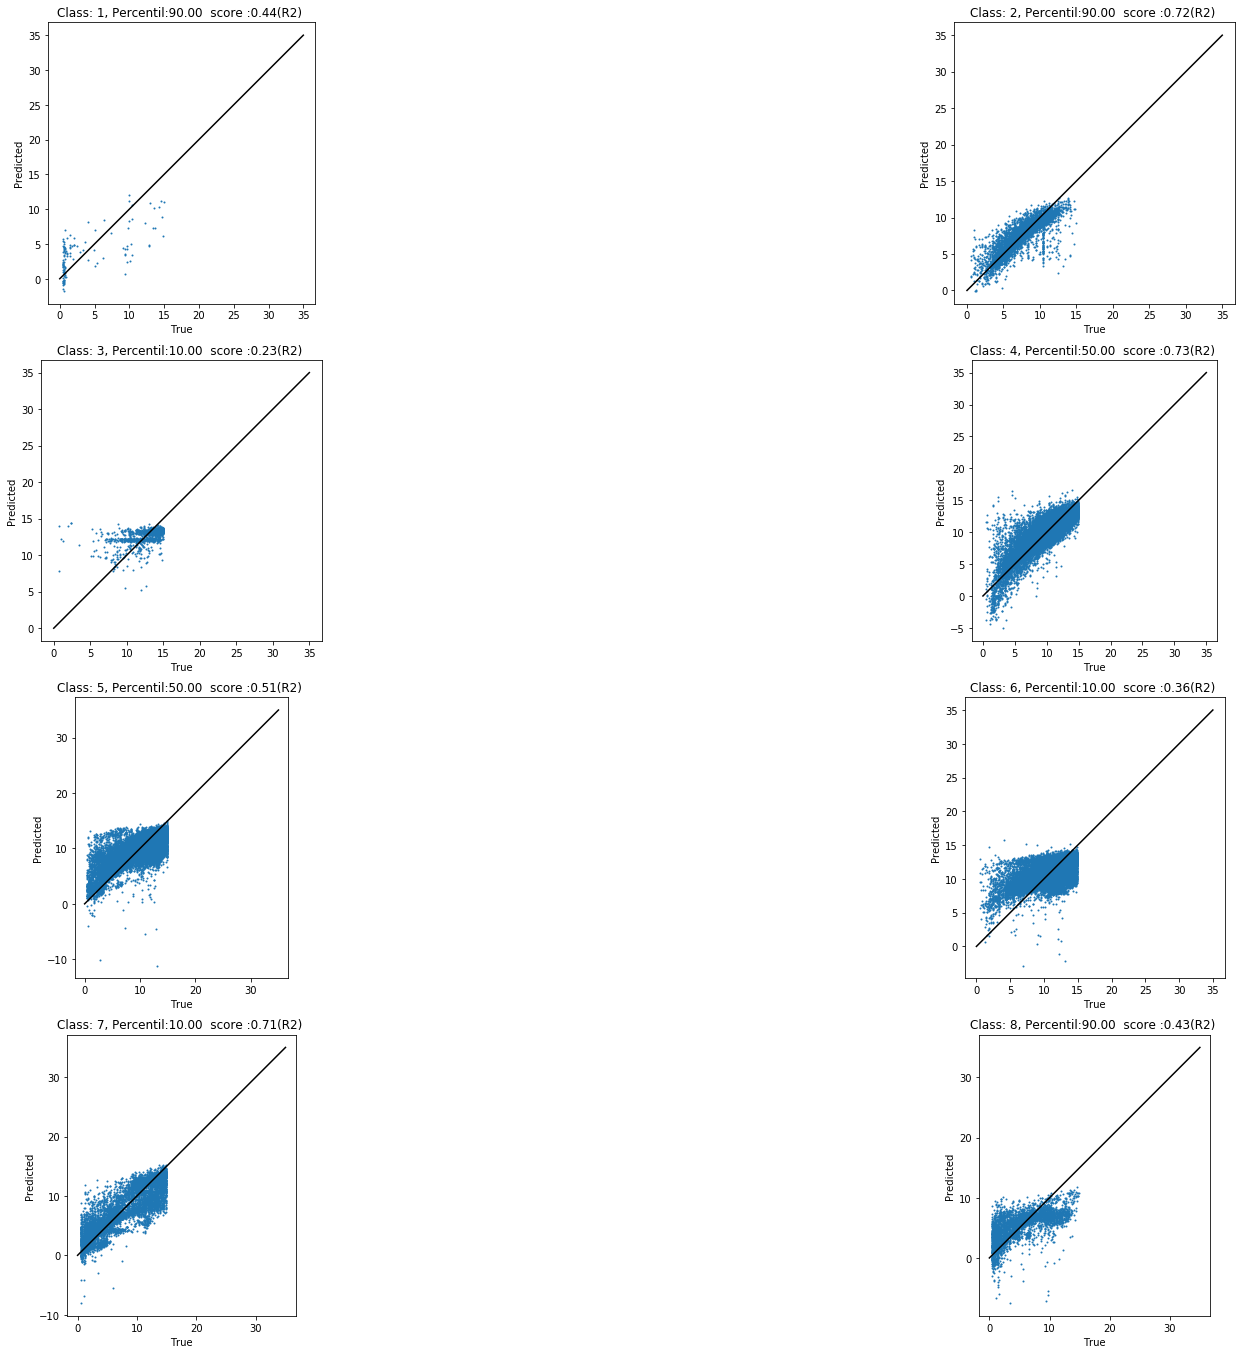

In [313]:
plt.figure(figsize=(30, 30))
count = 1 
models = {}

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = StumpfMod()

    # Index definition following Variance and class
    index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentPerDepth[c-1])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index *(SurveyValues<=BestDepth[c-1])
    
    # Finals models fitting for each class
    models[c].fit(X[ind].reshape(-1,1), SurveyValues[ind].reshape(np.sum(ind),1))
    
    # Result displaying
    print(models[c].score)
    plt.subplot(5, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=models[c].predict(X[ind].reshape(-1,1)),s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 35],[0, 35], c='k')
    plt.title('Class: {0:d}, Percentil:{1:0.2f}  score :{2:0.2f}(R2) '.format(c, PercentilRange[ClassModelbyDepth[BestDepth[c-1]][c]['R2']], models[c].score['R2'], models[c].score['RMS'],  int(models[c].score['Error'])))
    count = count +1

In [ ]:
print(PercentPerDepth)
print(BestDepth)
'''[60, 40, 50, 40, 75, 95, 80, 100]
[25, 20, 35, 20, 20, 10, 30, 20]'''
'''[20, 50, 20, 20, 20, 70, 20, 20]
[15, 20, 25, 15, 20, 25, 15, 25]'''

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  


{'averageDev': 5.7526920631091407e-13, 'Var': 1.7331004049970249, 'RMS': 1.3164727133507268, 'Error%': 11.938917240461375, 'Error': 0.93653173390240307, 'R2': 0.85706026784380174}
{'averageDev': -1.8966444695638479e-14, 'Var': 4.5162706130922396, 'RMS': 2.1251519035335424, 'Error%': 35.662876759190532, 'Error': 1.6180734099112215, 'R2': 0.75303633656347391}
{'averageDev': -8.2661932889148036e-13, 'Var': 6.2420596091123954, 'RMS': 2.4984114171033553, 'Error%': 20.330003334642647, 'Error': 1.954490256533798, 'R2': 0.63299106345245759}


"{'averageDev': 5.7526920631091407e-13, 'Var': 1.7331004049970249, 'RMS': 1.3164727133507268, 'Error%': 11.938917240461375, 'Error': 0.93653173390240307, 'R2': 0.85706026784380174}\n{'averageDev': -1.8966444695638479e-14, 'Var': 4.5162706130922396, 'RMS': 2.1251519035335424, 'Error%': 35.662876759190532, 'Error': 1.6180734099112215, 'R2': 0.75303633656347391}\n{'averageDev': -8.2661932889148036e-13, 'Var': 6.2420596091123954, 'RMS': 2.4984114171033553, 'Error%': 20.330003334642647, 'Error': 1.954490256533798, 'R2': 0.63299106345245759}"

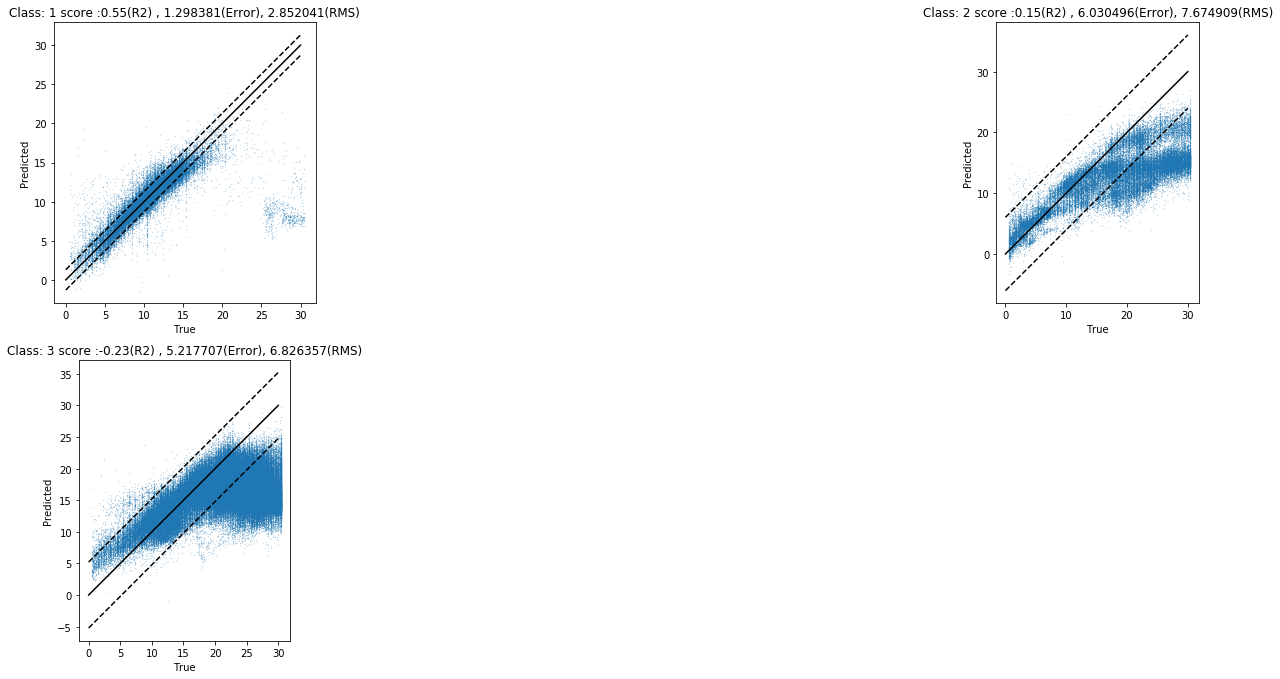

In [189]:
plt.figure(figsize=(30, 30))
count = 1 
NK_fold2 = 20 
ValidationMap = np.full(ClassifIndex.shape, np.NaN, dtype= np.float64)
models = {}

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = LyzengaMod()

    # Index definition following Variance and class
    index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentPerDepth[c-1])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index 
    Xk, Yk = X[ind], SurveyValues[ind]

    # Initialize folder
    divider = 1
    while True:
        percentiles = np.percentile(Yk, np.linspace(0, 100, int(divider*np.floor(len(Yk) /NK_fold2))))
        Fall_in = np.searchsorted(percentiles, Yk, side='right')
        if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold2:
            break
        divider = divider * 0.9

    temp = ValidationMap[ind] 
    skf = StratifiedKFold(n_splits=NK_fold2)
    #skf = KFold(n_splits=NK_fold2)
    skf.get_n_splits(Xk, Fall_in)#'''Line to check and updated with stratified'''
    # Validation on k folds
    '''for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):'''
    for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):
        models[c].fit(Xk[trI][Yk[trI]<=BestDepth[c-1]], Yk[trI][Yk[trI]<=BestDepth[c-1]])
        temp[teI] = models[c].predict(Xk[teI])
    ValidationMap[ind] = temp

    
    # Result displaying
    print(models[c].score)
    plt.subplot(5, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=ValidationMap[ind],s=0.01)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 30],[0, 30], c='k')
    scoreError = my_Error(SurveyValues[ind], ValidationMap[ind])
    plt.title('Class: {0:d} score :{1:0.2f}(R2) , {2:f}(Error), {3:f}(RMS)'.format(c,r2_score(SurveyValues[ind], ValidationMap[ind]), \
                                                                                         scoreError, \
                                                                                         my_RMS(SurveyValues[ind], ValidationMap[ind]))) 
    plt.plot([0, 30],[scoreError, 30+scoreError], c='k', linestyle='dashed')
    plt.plot([0, 30],[-scoreError, 30-scoreError], c='k',linestyle='dashed')
    count = count +1
    
'''{'averageDev': 5.7526920631091407e-13, 'Var': 1.7331004049970249, 'RMS': 1.3164727133507268, 'Error%': 11.938917240461375, 'Error': 0.93653173390240307, 'R2': 0.85706026784380174}
{'averageDev': -1.8966444695638479e-14, 'Var': 4.5162706130922396, 'RMS': 2.1251519035335424, 'Error%': 35.662876759190532, 'Error': 1.6180734099112215, 'R2': 0.75303633656347391}
{'averageDev': -8.2661932889148036e-13, 'Var': 6.2420596091123954, 'RMS': 2.4984114171033553, 'Error%': 20.330003334642647, 'Error': 1.954490256533798, 'R2': 0.63299106345245759}'''

In [23]:
npzfile = np.load('TrainMatrixGlob_all.npz')
ClassifIndex2 = npzfile['arr_1']

shapefile_path = ["/Users/selimamrari/Documents/PDM/NCP/Scripts/test/error.shp"]

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
geo_transform = src_ds.GetGeoTransform()
proj = src_ds.GetProjectionRef()

errors = vectors_to_raster(shapefile_path, RasterWidth, RasterHeight, geo_transform, proj)
errors = errors==True
ClassifIndex2[errors] = False
del errors

class2 = 'FullFinKmeansClassif_3Train1.1.tif'
file = '/Users/selimamrari/Documents/PDM/NCP/Classif/'
Classif2 = gdal.Open( file + class2 )
clusters_Classif2 = Classif2.GetRasterBand(1).ReadAsArray()
np.unique(clusters_Classif2)
ClassifIndex2[clusters_Classif2==0] = False

In [190]:
TestIndex = ~np.isnan(ValidationMap)

In [191]:
x,y = np.where(TestIndex)

In [192]:
ErrorEst = np.divide(np.abs(ValidationMap[TestIndex]-SurveyValues[TestIndex]),SurveyValues[TestIndex])

In [193]:
x = x[~np.isnan(ErrorEst)]
y = y[~np.isnan(ErrorEst)]
ErrorEst = ErrorEst[~np.isnan(ErrorEst)]

'sc.axes.get_yaxis().set_visible(False)\nsc.axes.get_xaxis().set_visible(False)'

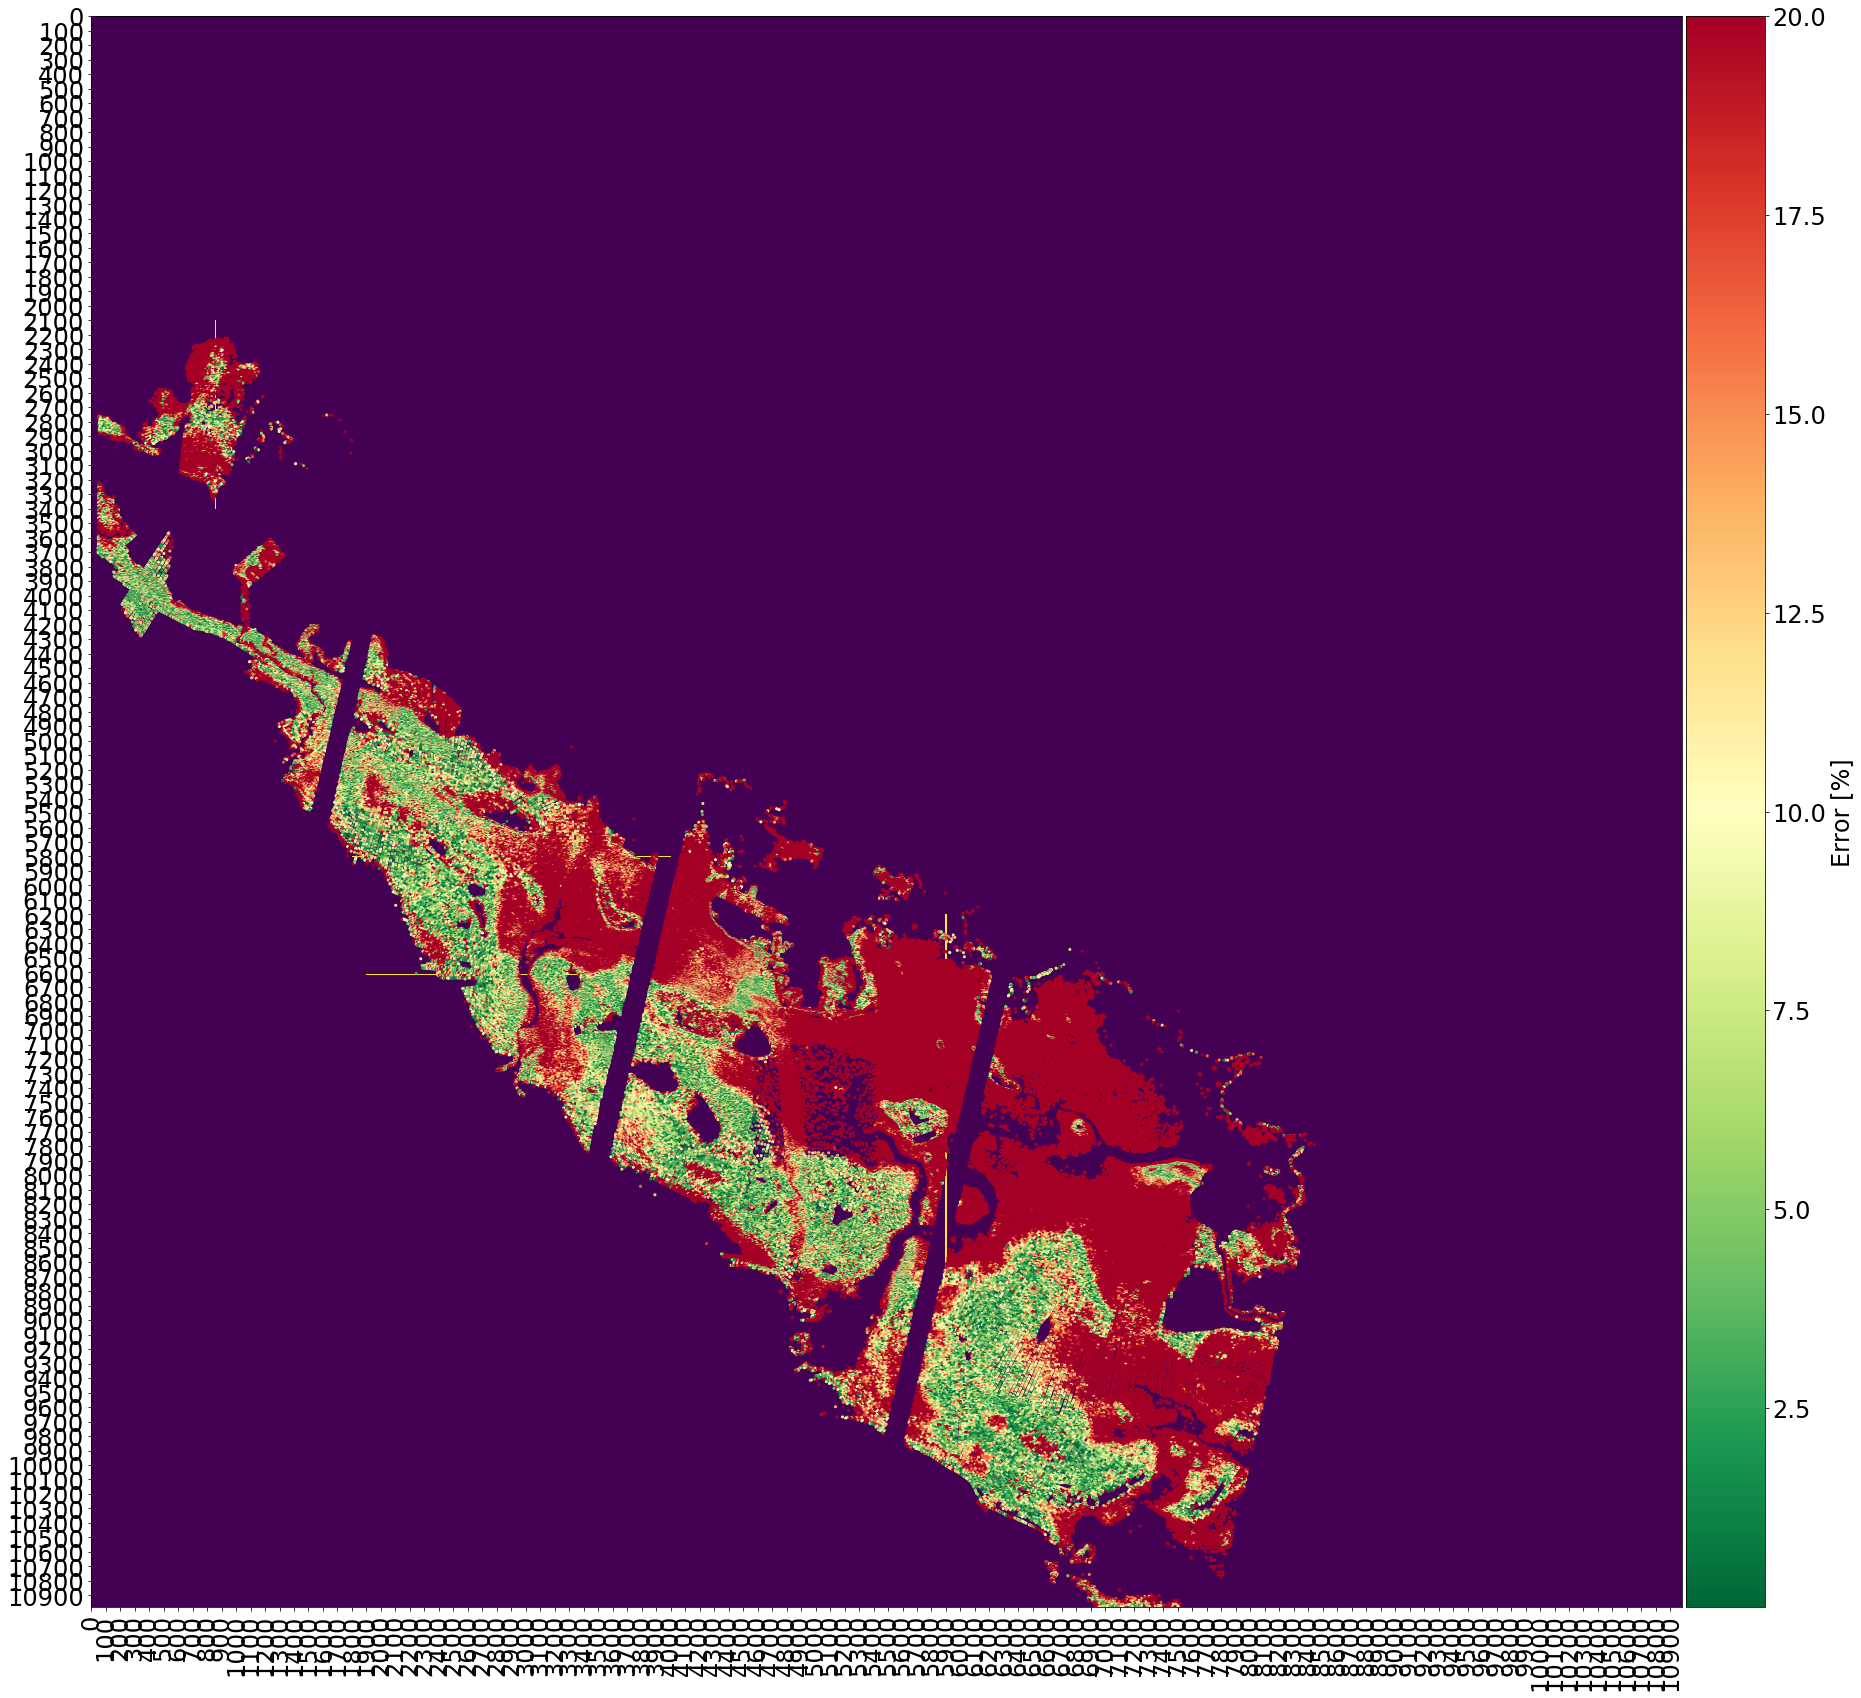

In [150]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(30,30), frameon=False)
ax=plt.gca()

'''plt.imshow(img_as_float(better_contrast))'''
plt.imshow(Loc)
ax.autoscale(False)
sc = plt.scatter(y,x,c=DisplayError, cmap='RdYlGn_r',s=4)

Etic = np.array([166,166.2,166.5,166.8])
'''plt.xticks(find_TickCord(max_E, min_E, Etic , 10980), tuple([str(i)+' °E' for i in Etic]),size=24)'''
plt.xticks(np.arange(0,10980,100),size=24, rotation=90)

Ntic = np.array([22, 22.2, 22.5])
'''plt.yticks(find_TickCord(-min_N, -max_N, Ntic , 10980), tuple([str(i)+' °S' for i in Ntic]),size=24)'''
plt.yticks(np.arange(0,10980,100),size=24)

divider = make_axes_locatable(ax)
Cax = divider.append_axes("right",size="5%", pad=0.05)

cbar = plt.colorbar(sc, cax=Cax)
cbar.set_label(label='Error [%]', size=24)
cbar.ax.set_yticklabels(cbar.ax.get_yticklabels(),fontsize=24)

'''sc.axes.get_yaxis().set_visible(False)
sc.axes.get_xaxis().set_visible(False)'''


In [34]:
np.zeros(ErrorEst.shape)

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [30]:


def find_TickCord(max_E, min_E, Coords, shape):
    Range = max_E - min_E 
    loc = Coords-min_E
    result = loc*shape /Range
    return tuple([int(round(i)) for i in result])
find_TickCord(max_E, min_E, np.array([166,166.5]) , 10980)

(275, 5483)

In [35]:
src_ds=gdal.Open('/Users/selimamrari/Documents/PDM/NCP/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/GRANULE/L1C_T58KFA_A010823_20170718T231219/IMG_DATA/Deglinted/Compo.tif')
RGB_img = np.dstack((src_ds.GetRasterBand(1).ReadAsArray(),\
                     src_ds.GetRasterBand(2).ReadAsArray(),\
                     src_ds.GetRasterBand(3).ReadAsArray()))
better_contrast = np.empty(RGB_img.shape, dtype= RGB_img.dtype)

p_min = 2
p_max = 98
for i in range(RGB_img.shape[2]):
    v_min, v_max = np.percentile(RGB_img[:,:,i], (p_min, p_max))
    print('percentiles ',p_min,', ',p_max,' of band ',str(i),': ',str(v_min),', ',str(v_max),'\n')
    better_contrast[:,:,i] = exposure.rescale_intensity(RGB_img[:,:,i], in_range=(v_min, v_max))
    
del RGB_img

percentiles  2 ,  98  of band  0 :  0.0 ,  1520.0 

percentiles  2 ,  98  of band  1 :  0.0 ,  1645.0 

percentiles  2 ,  98  of band  2 :  0.0 ,  1841.0 



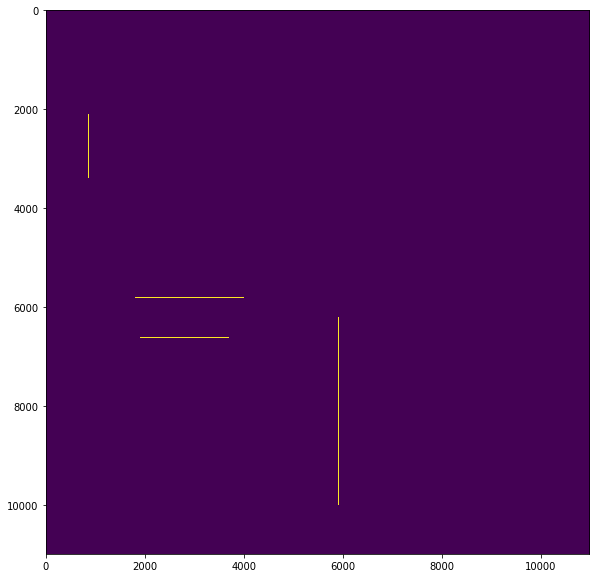

In [122]:
plt.figure(figsize=(10,10))
Loc = np.zeros(ClassifIndex.shape)

Loc[6610 : 6620,1900:3700] = 1
Loc[5795 :5805,1800:4000] = 1
Loc[2100:3400,855: 865] = 1
Loc[6200 : 10000, 5895 : 5905] = 1

plt.imshow(Loc)

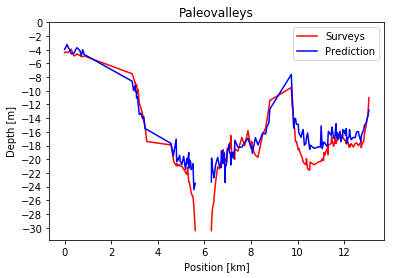

In [194]:
TracInd = np.logical_and(np.logical_and(6610 < x,x < 6620),np.logical_and(y>1900,y<3700))
Position = y[TracInd]
TrueVal = SurveyValues[TestIndex][TracInd]
PredictVal = ValidationMap[TestIndex][TracInd]

Position, indd = np.unique(Position, return_index=True)
TrueVal =  TrueVal[indd] 
PredictVal =  PredictVal[indd] 

Position = Position - np.min(Position)
Position = Position/100


plt.plot(Position[0:53],-TrueVal[0:53],'r',label='Surveys')
plt.plot(Position[0:53],-PredictVal[0:53],'b',label='Prediction')
plt.legend()
plt.plot(Position[53:],-TrueVal[53:],'r',label='Surveys')
plt.plot(Position[53:],-PredictVal[53:],'b',label='Prediction')

plt.yticks(np.arange(0,np.min(-TrueVal),-2))

plt.xlabel('Position [km]')
plt.ylabel('Depth [m]')
plt.title('Paleovalleys')


In [168]:
np.arange(0,np.min(-TrueVal),-2)

array([  0.,  -2.,  -4.,  -6.,  -8., -10., -12., -14., -16., -18., -20.,
       -22., -24., -26., -28., -30.])

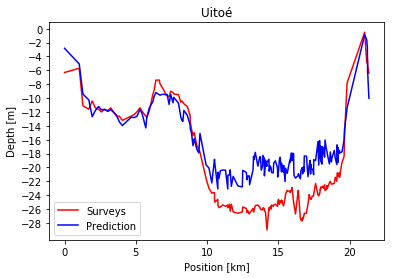

In [195]:
TracInd = np.logical_and(np.logical_and(5795 < x,x < 5805),y<4000)
Position = y[TracInd]
TrueVal = SurveyValues[TestIndex][TracInd]
PredictVal = ValidationMap[TestIndex][TracInd]

Position, indd = np.unique(Position, return_index=True)
TrueVal =  TrueVal[indd] 
PredictVal =  PredictVal[indd] 

Position = Position - np.min(Position)
Position = Position/100

plt.plot(Position,-TrueVal,'r',label='Surveys')
plt.plot(Position,-PredictVal,'b',label='Prediction')
plt.legend()

plt.xlabel('Position [km]')
plt.ylabel('Depth [m]')
plt.yticks(np.arange(0,np.min(-TrueVal),-2))

plt.title('Uitoé')



In [100]:
np.where(TrueVal==30.41)

(array([52, 53]),)

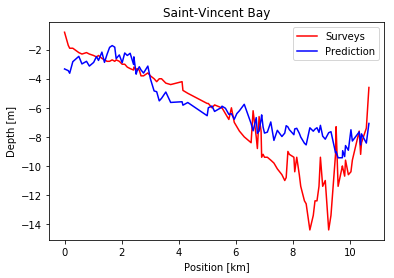

In [196]:
TracInd = np.logical_and(np.logical_and(855 < y,y < 865),x<3400)
Position = x[TracInd]
TrueVal = SurveyValues[TestIndex][TracInd]
PredictVal = ValidationMap[TestIndex][TracInd]

Position, indd = np.unique(Position, return_index=True)
TrueVal =  TrueVal[indd] 
PredictVal =  PredictVal[indd] 

Position = Position - np.min(Position)
Position = Position/100

plt.plot(Position,-TrueVal,'r',label='Surveys')
plt.plot(Position,-PredictVal,'b',label='Prediction')
plt.xlabel('Position [km]')
plt.ylabel('Depth [m]')
plt.legend()
plt.title('Saint-Vincent Bay')

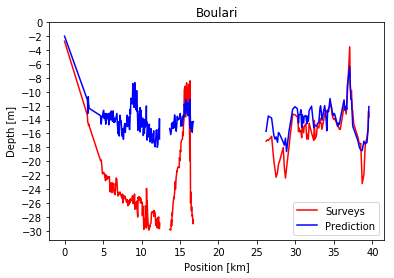

In [197]:
TracInd = np.logical_and(5895 < y,y < 5905)
Position = x[TracInd]
TrueVal = SurveyValues[TestIndex][TracInd]
PredictVal = ValidationMap[TestIndex][TracInd]

Position, indd = np.unique(Position, return_index=True)
TrueVal =  TrueVal[indd] 
PredictVal =  PredictVal[indd] 

Position = Position - np.min(Position)
Position = Position/100


plt.plot(Position[0:168],-TrueVal[0:168],'r',label='Surveys')
plt.plot(Position[0:168],-PredictVal[0:168],'b',label='Prediction')
plt.legend()
plt.plot(Position[285:],-TrueVal[285:],'r',label='Surveys')
plt.plot(Position[285:],-PredictVal[285:],'b',label='Prediction')
plt.plot(Position[211:269],-TrueVal[211:269],'r',label='Surveys')
plt.plot(Position[211:269],-PredictVal[211:269],'b',label='Prediction')
plt.yticks(np.arange(0,np.min(-TrueVal),-2))

plt.xlabel('Position [km]')
plt.ylabel('Depth [m]')
plt.title('Boulari')


In [156]:
np.sum(ClassifIndex)*100

2074580900

In [55]:
Position = x[np.logical_and(855 < y,y < 865)]
Er = ErrorEst[np.logical_and(855 < y,y < 865)]
if len(Position)!=len(np.unique(Postion)):
    Doublon = (Position[0:-1]-Position[1:])==0
    Doublon2 = np.where(Doublon)
    
    if np.argmax(Er[Doublon],Er[Doublon2[0]+1])

array([  3.11791516e+00,   1.01861942e+00,   9.00687565e-01,
         4.84443727e-01,   1.17121650e-01,   2.94071403e-01,
         2.71695687e-01,   3.57654836e-01,   1.97619982e-01,
         1.13307016e-02,   1.39973365e-01,   1.65911200e-01,
         6.29181684e-02,   1.70213667e-01,   3.41510486e-01,
         3.62344693e-01,   3.46612321e-01,   3.16958568e-02,
         1.56253948e-01,   3.41953375e-02,   2.57095892e-01,
         2.49547511e-01,   3.18193846e-01,   1.12389441e-01,
         2.20355775e-01,   8.36454786e-02,   5.42694461e-02,
         6.60306420e-02,   1.06837814e-01,   5.06506213e-02,
         1.30751119e-01,   5.39529993e-02,   2.09399323e-01,
         1.63776801e-01,   3.79625128e-01,   3.36097346e-01,
         1.42162803e-01,   2.78781359e-01,   3.28137417e-01,
         2.11608470e-01,   1.26861293e-01,   1.47535026e-01,
         5.16994093e-02,   2.03138329e-02,   7.71247215e-02,
         5.82791603e-03,   1.90408127e-02,   5.76726079e-02,
         5.11116945e-02,

In [39]:
threshold = 0.2
DisplayError = np.full(ErrorEst.shape, np.NaN, dtype=np.float64)
DisplayError[ErrorEst<threshold] = ErrorEst[ErrorEst<threshold]
DisplayError[np.isnan(DisplayError)] = threshold
DisplayError= 100*DisplayError

In [72]:
write_raster2('BathyEstimatedMapLim.tiff', BathyMap, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Float64)

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


{'averageDev': -1.2424530143642781e-05, 'Var': 1.705770661438083, 'RMS': 1.3060515538975033, 'Error%': 14.398352846129095, 'Error': 0.92189807366681631, 'R2': 0.81412168437719212}
{'averageDev': -7.9028860470319112e-06, 'Var': 12.295093123341134, 'RMS': 3.5064359573990704, 'Error%': 62.167315672872711, 'Error': 2.9299788671222657, 'R2': 0.83499185197412262}
{'averageDev': -4.1138835862769553e-06, 'Var': 10.809291935717402, 'RMS': 3.2877487640811913, 'Error%': 19.715282812471404, 'Error': 2.5758254676203989, 'R2': 0.61815597429595215}


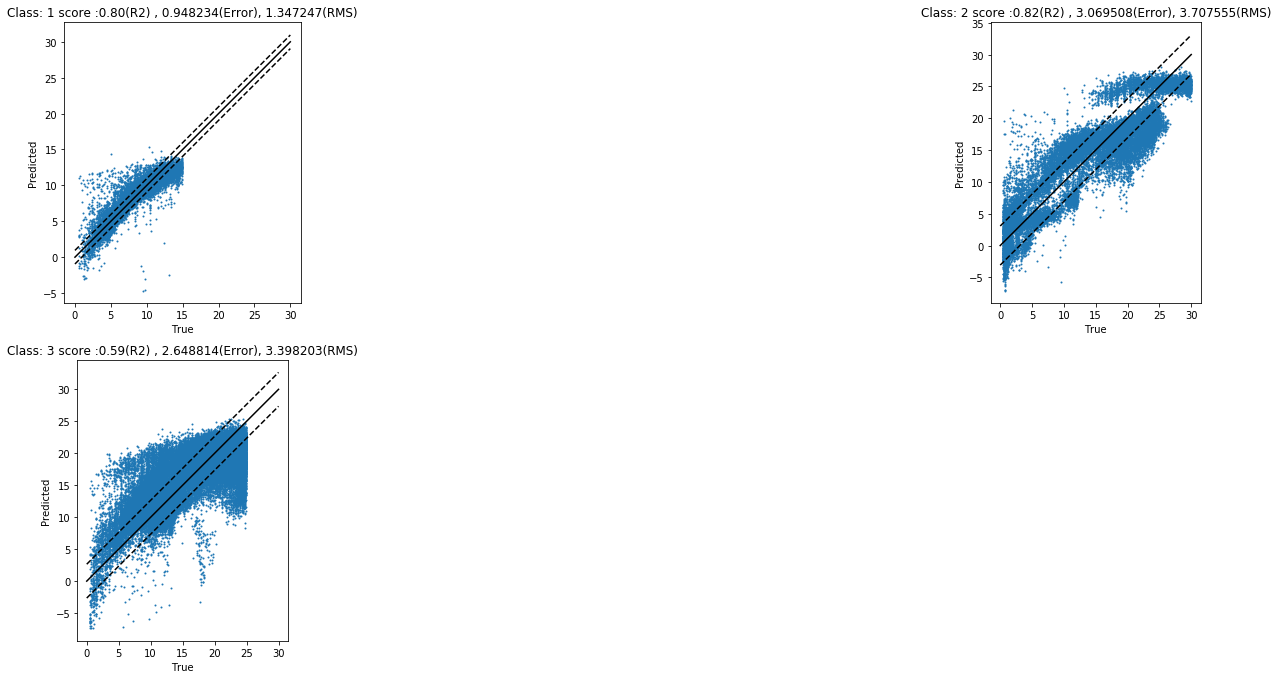

In [465]:
plt.figure(figsize=(30, 30))
count = 1 
NK_fold2 = 20 
ValidationMap = np.full(ClassifIndex.shape, np.NaN, dtype= np.float64)
models = {}

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = StumpfMod()

    # Index definition following Variance and class
    index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentPerDepth[c-1])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index *(SurveyValues<=BestDepth[c-1])* FP
    Xk, Yk = X[ind], SurveyValues[ind]

    # Initialize folder
    divider = 1
    while True:
        percentiles = np.percentile(Yk, np.linspace(0, 100, int(divider*np.floor(len(Yk) /NK_fold2))))
        Fall_in = np.searchsorted(percentiles, Yk, side='right')
        if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold2:
            break
        divider = divider * 0.9

    temp = ValidationMap[ind] 
    skf = StratifiedKFold(n_splits=NK_fold2)
    #skf = KFold(n_splits=NK_fold2)
    skf.get_n_splits(Xk, Fall_in)#'''Line to check and updated with stratified'''
    # Validation on k folds
    '''for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):'''
    for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):
        models[c].fit(Xk[trI].reshape(-1,1), Yk[trI])
        temp[teI] = models[c].predict(Xk[teI].reshape(-1,1))
    ValidationMap[ind] = temp

    
    # Result displaying
    print(models[c].score)
    plt.subplot(5, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=ValidationMap[ind],s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 30],[0, 30], c='k')
    scoreError = my_Error(SurveyValues[ind], ValidationMap[ind])
    plt.title('Class: {0:d} score :{1:0.2f}(R2) , {2:f}(Error), {3:f}(RMS)'.format(c,r2_score(SurveyValues[ind], ValidationMap[ind]), \
                                                                                         scoreError, \
                                                                                         my_RMS(SurveyValues[ind], ValidationMap[ind]))) 
    plt.plot([0, 30],[scoreError, 30+scoreError], c='k', linestyle='dashed')
    plt.plot([0, 30],[-scoreError, 30-scoreError], c='k',linestyle='dashed')
    count = count +1
    
plt.savefig("Results/Figures/"+class1+'Stumpf3_Rest_R2.png', dpi='figure')



In [466]:
PercentPerDepth

[99, 88, 10]

In [450]:
npzfile = np.load('Lyzenga8clust.npz')
B, P =  npzfile['arr_0'], npzfile['arr_1']

In [451]:
P

array({'BestDepthR': [54, 94, 73, 99, 10, 10, 55, 80], 'BestDepthError': [56, 94, 72, 67, 100, 50, 55, 57], 'BestDepthRMS': [55, 94, 72, 98, 100, 10, 55, 57], 'BestDepthErrorP': [55, 95, 74, 57, 100, 80, 10, 100]}, dtype=object)

In [452]:
PercentPerDepth = [54, 94, 73, 99, 10, 10, 55, 80]

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app


{'averageDev': 2.3314683517128287e-15, 'Var': 10.05648353594338, 'RMS': 3.1711959157301179, 'Error%': 98.828686378064248, 'Error': 2.1770404952778453, 'R2': 0.80476198909355889}
{'averageDev': -7.1718332207561506e-15, 'Var': 0.66949366665369625, 'RMS': 0.81822592641256253, 'Error%': 10.983807469772294, 'Error': 0.57057954442093628, 'R2': 0.81976962948427479}
{'averageDev': 3.6501349451256811e-13, 'Var': 1.9832422329298396, 'RMS': 1.4082763340090039, 'Error%': 6.4649816675492566, 'Error': 1.0461920449610655, 'R2': 0.40633789019203492}
{'averageDev': 5.2398835925279702e-13, 'Var': 1.6478092872148642, 'RMS': 1.2836702408386915, 'Error%': 11.517087745892951, 'Error': 0.9430688309819838, 'R2': 0.85873614669809684}
{'averageDev': 3.4236513138888551e-13, 'Var': 10.353126000639081, 'RMS': 3.2176273868549603, 'Error%': 33.596089789711733, 'Error': 2.5300836852157844, 'R2': 0.57899749109340171}
{'averageDev': -5.2196498656249172e-14, 'Var': 5.4127479172341451, 'RMS': 2.3265313058788064, 'Error%'

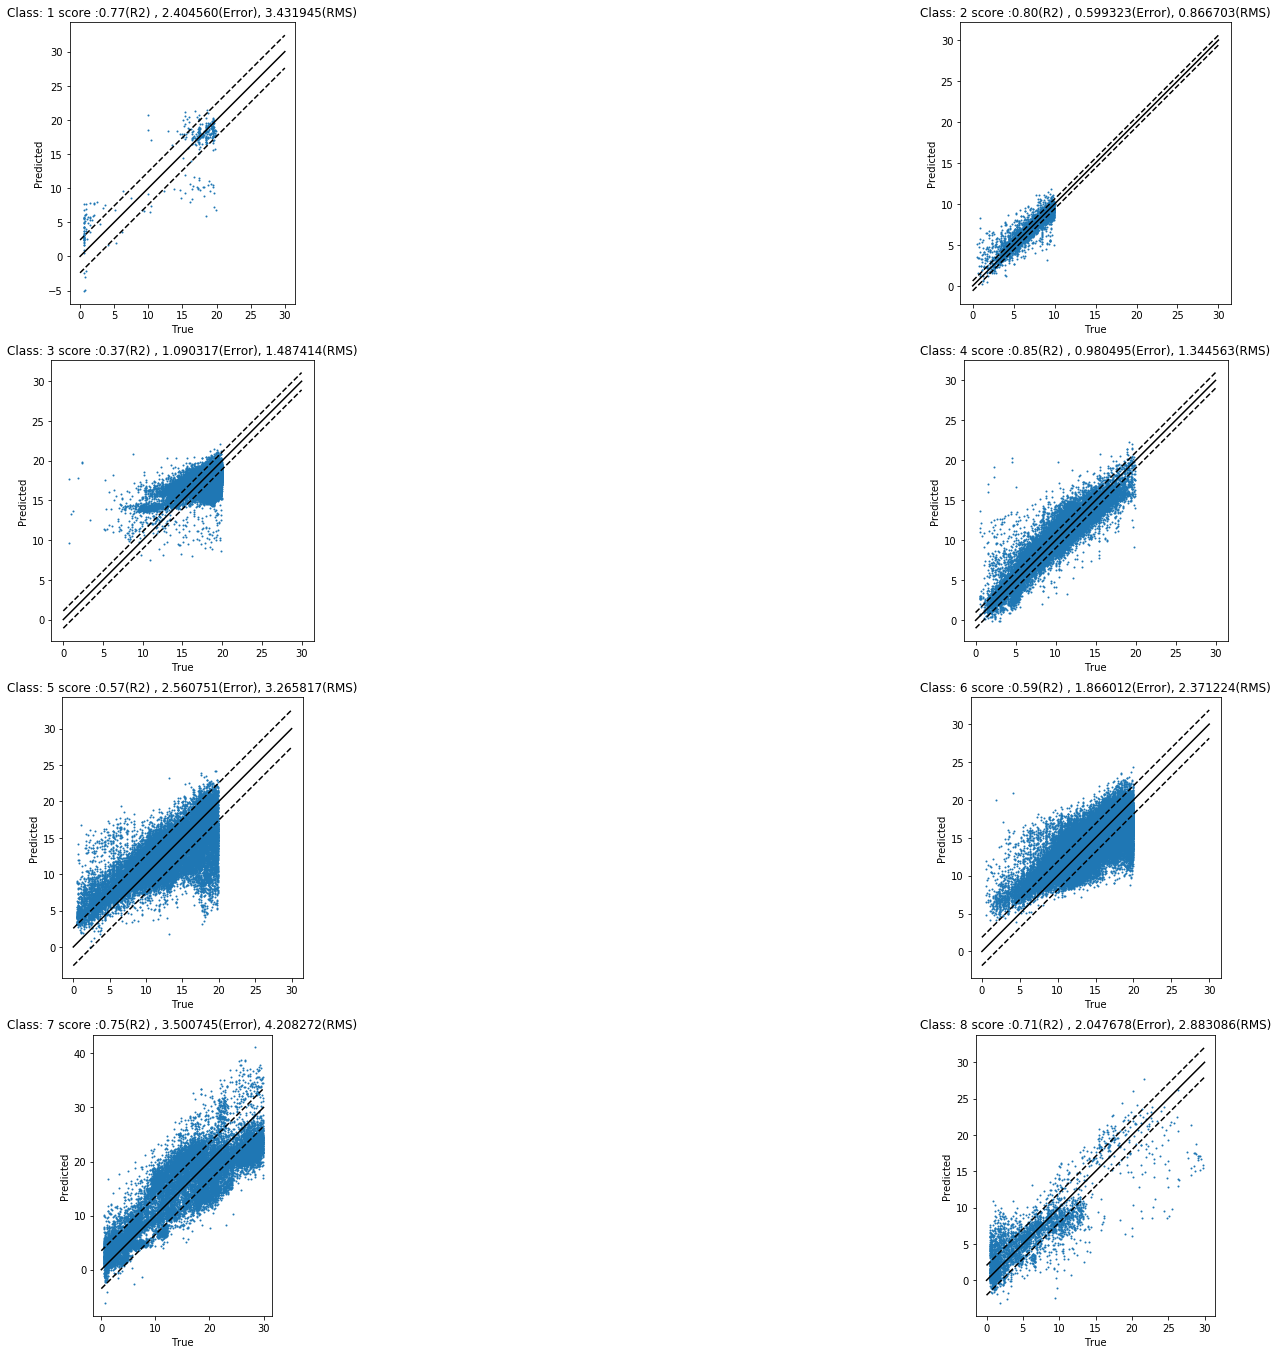

In [453]:
plt.figure(figsize=(30, 30))
count = 1 
NK_fold2 = 20 
ValidationMap = np.full(ClassifIndex.shape, np.NaN, dtype= np.float64)
models = {}

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = LyzengaMod()

    # Index definition following Variance and class
    index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentPerDepth[c-1])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index *(SurveyValues<=BestDepth[c-1])
    Xk, Yk = X[ind], SurveyValues[ind]

    # Initialize folder
    divider = 1
    while True:
        percentiles = np.percentile(Yk, np.linspace(0, 100, int(divider*np.floor(len(Yk) /NK_fold2))))
        Fall_in = np.searchsorted(percentiles, Yk, side='right')
        if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold2:
            break
        divider = divider * 0.9

    temp = ValidationMap[ind] 
    skf = StratifiedKFold(n_splits=NK_fold2)
    #skf = KFold(n_splits=NK_fold2)
    skf.get_n_splits(Xk, Fall_in)#'''Line to check and updated with stratified'''
    # Validation on k folds
    '''for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):'''
    for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):
        models[c].fit(Xk[trI], Yk[trI])
        temp[teI] = models[c].predict(Xk[teI])
    ValidationMap[ind] = temp

    
    # Result displaying
    print(models[c].score)
    plt.subplot(5, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=ValidationMap[ind],s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 30],[0, 30], c='k')
    scoreError = my_Error(SurveyValues[ind], ValidationMap[ind])
    plt.title('Class: {0:d} score :{1:0.2f}(R2) , {2:f}(Error), {3:f}(RMS)'.format(c,r2_score(SurveyValues[ind], ValidationMap[ind]), \
                                                                                         scoreError, \
                                                                                         my_RMS(SurveyValues[ind], ValidationMap[ind]))) 
    plt.plot([0, 30],[scoreError, 30+scoreError], c='k', linestyle='dashed')
    plt.plot([0, 30],[-scoreError, 30-scoreError], c='k',linestyle='dashed')
    count = count +1
    


In [446]:
PercentPerDepth

[71, 100, 50]

# Grid Search on each class model

In [ ]:
functionPos = {'averageDev': np.argmin, 'Var': np.argmin, 'RMS': np.argmin, 'Error%': np.argmin, 'Error': np.argmin, 'R2': np.argmax}
functionBS = {'averageDev': np.min, 'Var': np.min, 'RMS': np.min, 'Error%': np.min, 'Error': np.min, 'R2': np.max}

models = {}
count = 1 
ClassModelbyScore = {}
BestParam = {}
PercentilRange = range(40, 101, 10)
FoldsScores = {}
NK_fold = 4

# Class and model initialization
for c in np.unique(clusters_Classif):
    # Avoid empty class
    if c ==0:
        continue
    print('Processing class' + str(c))
    models[c] = LyzengaMod()
    BestParam[c] = {}
    ClassModelbyScore[c] = {}
    
    # Grid Search on hyperParam
    PercentScores = {}      
    for bornIndex in PercentilRange:
        PercentScores[bornIndex] = {}
        index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],bornIndex)
        ind = (clusters_Classif==c) * (SurveyIndex>0) * index
        Xk, Yk = X[ind], SurveyValues[ind].reshape(np.sum(ind),1)
        
        # FoldScore initialization
        for ScoreName in testmode.score.keys():
            FoldsScores[ScoreName] = []
        
        # Initialize folder
        divider = 1
        while True:
            percentiles = np.percentile(Yk, np.linspace(0, 100, int(divider*np.floor(len(Yk) /NK_fold))))
            Fall_in = np.searchsorted(percentiles, Yk, side='right')
            if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold:
                break
            divider = divider * 0.9
            
        skf = StratifiedKFold(n_splits=NK_fold)
        #skf = KFold(n_splits=NK_fold)
        skf.get_n_splits(Xk, Fall_in)#'''Line to check and updated with stratified'''
        # Validation on k folds
        '''for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):'''
        for trI, teI in skf.split(Xk, Fall_in.reshape(len(Fall_in),)):
            models[c].fit(Xk[trI], Yk[trI])
            models[c].predictEval(Xk[teI], Yk[teI])
            
            # Foldscores recording
            for ScoreName in models[c].Testscore.keys():
                FoldsScores[ScoreName].append(models[c].Testscore[ScoreName])
                
        # Average Foldscore recording on percentile parameter
        for ScoreName in testmode.score.keys():        
            PercentScores[bornIndex][ScoreName] = np.mean(FoldsScores[ScoreName])
    
    # Best scores recording along all average Foldscore depending on percentile parameter
    for bornIndex in PercentilRange:    
        for ScoreName in testmode.score.keys():
            ClassModelbyScore[c][ScoreName] = functionPos[ScoreName]([PercentScores[k][ScoreName] for k in PercentScores.keys()])
            BestParam[c][ScoreName] = functionBS[ScoreName]([PercentScores[k][ScoreName] for k in PercentScores.keys()])
    print('Best Scores for class '+ str(c) + ', with  ' + str(PercentilRange[ClassModelbyScore[c]['R2']])+' following R2:')
    print(PercentScores[PercentilRange[ClassModelbyScore[c]['R2']]], end='\n\n')
    print('Best Scores for class '+ str(c) + ', on each StatScores   :')
    print(BestParam[c])
    print( 20*'=')

In [ ]:

ClassModelbyScore[c]['R2']

In [ ]:
values, base = np.histogram(SurveyVariance[~np.isnan(SurveyVariance)], bins=100, normed='True')
dx = base[1] - base[0]
plt.plot(base[1:], np.cumsum(values)*dx)
plt.show()
np.median(SurveyVariance[~np.isnan(SurveyVariance)])


In [ ]:
Best Scores for class 1, with  70 following R2:
{'averageDev': 0.11865180640360816, 'Var': 9.1761754942995477, 'RMS': 2.0786650325703082, 'Error%': 1.4615741041133925, 'Error': 2.0786650325703082, 'R2': 0.23496088781742716}

Best Scores for class 1, on each StatScores   :
{'averageDev': -0.1057675240738794, 'Var': 6.196120584756649, 'RMS': 1.6036093873263617, 'Error%': 0.67546079455093067, 'Error': 1.6036093873263617, 'R2': 0.23496088781742716}
==========
Processing class2
Best Scores for class 2, with  40 following R2:
{'averageDev': 0.013566144614791303, 'Var': 12.325621311682166, 'RMS': 2.787131304391643, 'Error%': 0.20896625349681436, 'Error': 2.787131304391643, 'R2': 0.43509451937616506}

Best Scores for class 2, on each StatScores   :
{'averageDev': 0.013566144614791303, 'Var': 12.325621311682166, 'RMS': 2.787131304391643, 'Error%': 0.20896625349681436, 'Error': 2.787131304391643, 'R2': 0.43509451937616506}
==========
Processing class3
Best Scores for class 3, with  100 following R2:
{'averageDev': 0.10001010594354359, 'Var': 15.6101387233088, 'RMS': 3.213216559258643, 'Error%': 0.77410893669820746, 'Error': 3.213216559258643, 'R2': 0.54873830306719995}

Best Scores for class 3, on each StatScores   :
{'averageDev': 0.10001010594354359, 'Var': 15.6101387233088, 'RMS': 3.213216559258643, 'Error%': 0.75466370081990708, 'Error': 3.213216559258643, 'R2': 0.54873830306719995}
==========
Processing class4
Best Scores for class 4, with  80 following R2:
{'averageDev': 0.24567980755878591, 'Var': 25.947804122662593, 'RMS': 4.2280391611860191, 'Error%': 0.46230986540788871, 'Error': 4.2280391611860191, 'R2': 0.32343256265474046}

Best Scores for class 4, on each StatScores   :
{'averageDev': 0.24567980755878591, 'Var': 23.480838709142205, 'RMS': 4.0094717060349891, 'Error%': 0.42514460038536156, 'Error': 4.0094717060349891, 'R2': 0.32343256265474046}
==========
Processing class5
Best Scores for class 5, with  100 following R2:
{'averageDev': 0.15881409133719832, 'Var': 8.9416985834457634, 'RMS': 2.486633866055552, 'Error%': 0.13523608697926137, 'Error': 2.486633866055552, 'R2': -0.027665388553828357}

Best Scores for class 5, on each StatScores   :
{'averageDev': 0.0026365817273935471, 'Var': 8.7717279316504371, 'RMS': 2.3923542195486536, 'Error%': 0.13070216818172531, 'Error': 2.3923542195486536, 'R2': -0.027665388553828357}
==========
Processing class6
Best Scores for class 6, with  90 following R2:
{'averageDev': -0.018415813323996163, 'Var': 1.4100570020272269, 'RMS': 0.75336013903168508, 'Error%': 0.15505420051984109, 'Error': 0.75336013903168508, 'R2': 0.76252660810915951}

Best Scores for class 6, on each StatScores   :
{'averageDev': -0.030192555199878381, 'Var': 1.4100570020272269, 'RMS': 0.75336013903168508, 'Error%': 0.15505420051984109, 'Error': 0.75336013903168508, 'R2': 0.76252660810915951}
==========
Processing class7
Best Scores for class 7, with  80 following R2:
{'averageDev': -0.0046707219491556595, 'Var': 9.5330601044493548, 'RMS': 2.3165561695448758, 'Error%': 2.0765243906067923, 'Error': 2.3165561695448758, 'R2': 0.61855560723431124}

Best Scores for class 7, on each StatScores   :
{'averageDev': -0.051599263072741111, 'Var': 9.3353421595341288, 'RMS': 2.2974388532930452, 'Error%': 1.9118197044792886, 'Error': 2.2974388532930452, 'R2': 0.61855560723431124}
==========
Processing class8
Best Scores for class 8, with  100 following R2:
{'averageDev': -0.029205959160400988, 'Var': 2.3251593770734398, 'RMS': 1.0836902564553621, 'Error%': 0.15416769240292832, 'Error': 1.0836902564553621, 'R2': 0.76379698488743553}

Best Scores for class 8, on each StatScores   :
{'averageDev': -0.029205959160400988, 'Var': 2.2998101278478238, 'RMS': 1.0674090170233703, 'Error%': 0.1495406101895061, 'Error': 1.0674090170233703, 'R2': 0.76379698488743553}
==========

# Models computation folowing best parameters for each class

In [ ]:
plt.figure(figsize=(30, 30))
count = 1 

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = LyzengaMod()
    
    # Index definition following Variance and class
    index = SurveyVariance <= np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentilRange[ClassModelbyScore[c]['R2']])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index
    
    # Finals models fitting for each class
    models[c].fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))
    
    # Result displaying
    print(models[c].score)
    plt.subplot(4, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=models[c].predict(X[ind]),s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 50],[0, 50], c='k')
    plt.title('Class: {0:d}, Percentil:{1:0.2f}  score :{2:0.2f}(R2), {3:0.2f}(RMS), {4:d}(Er) '.format(c, PercentilRange[ClassModelbyScore[c]['R2']], models[c].score['R2'], models[c].score['RMS'],  int(models[c].score['Error'])))
    count = count +1

In [ ]:
PercentilRange[ClassModelbyScore[1]['R2']]

In [ ]:
help(LyzengaMod)

In [ ]:
models[c].Parameters.shape[0]

In [ ]:
index = SurveyVariance < np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],bornIndex)

In [ ]:
plt.figure(figsize=(30, 30))
models = {}
count = 1 
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index
    models[c] = LyzengaMod()
    models[c].fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))
    print(models[c].score)
    plt.subplot(4, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=models[c].predict(X[ind]),s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 50],[0, 50], c='k')
    plt.title('Class: {0:d}, score :{1:0.2f} '.format(c, models[c].score['R2']))
    count = count +1

In [ ]:

fig = plt.figure(figsize=(35, 35))

plt.imshow(clusters_Classif, cmap=plt.get_cmap('CMRmap'))


num_colors = 10
cm = plt.get_cmap('CMRmap') 
scheme = [cm(i*1./num_colors) for i in range(num_colors)] 
bins = np.linspace(1, 9, num_colors)  
ax_legend = fig.add_axes([0.9, 0.1, 0.01, 0.8]) 
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.set_ticks([i+0.5 for i in range(1, num_colors+1, 1)])  

cb.set_ticklabels([str(i+0.5) for i in range(1, num_colors+1, 1)])

'''plt.colorbar()'''

In [ ]:
np.linspace(1, 9, num_colors) 

In [ ]:
plt.figure(figsize=(35, 35))
count = 1 
for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    plt.subplot(4, 2, count, aspect='equal')
    plt.imshow(clusters_Classif==i)
    plt.title('Class: {0:d}, score :{1:0.2f} '.format(i, models[i].score['R2']))
    count = count +1

In [ ]:
EstimateValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)

for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = np.logical_and(clusters_Classif==i, ~SurveyIndex)
    EstimateValues[ind] = models[i].predict(X[ind]).reshape(np.sum(ind),)

plt.figure(figsize=(30, 30))
plt.imshow(EstimateValues)

In [ ]:
plt.figure(figsize=(20, 20))

plt.imshow(clusters_Classif==6)

In [ ]:
write_raster2('EstimsateBathy.tiff', EstimateValues, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Float64)

In [ ]:
clusters_band = Classif.GetRasterBand(1)

driver = ogr.GetDriverByName("ESRI Shapefile")
if os.path.exists(Classif_Tiff_File[:-4]+".shp"):
    driver.DeleteDataSource(Classif_Tiff_File[:-4]+".shp")
outDatasource = driver.CreateDataSource(Classif_Tiff_File[:-4]+ ".shp")
outLayer = outDatasource.CreateLayer(Classif_Tiff_File[:-4], srs=None)
gdal.Polygonize( clusters_band, None, outLayer, -1, [], callback=None )
outDatasource.Destroy()
sourceRaster = None

In [ ]:
Yk = np.random.randint(1,100,100)
percentiles = np.percentile(Yk, np.linspace(0, 100, int(n_samples /NK_fold)))
Fall_in = np.searchsorted(percentiles, Yk)

In [ ]:
while True:
    if np.min([np.sum(Fall_in == k) for k in np.unique(Fall_in)])>=NK_fold:
        break


In [ ]:
Yk

In [ ]:
values, base = np.histogram(Yk, bins=25, normed='True')
dx = base[1] - base[0]
plt.plot(base[1:], np.cumsum(values)*dx)
plt.show()
np.sort(Yk)